In [30]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from scipy import stats
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import sys

In [31]:
start_day_to_analyze = '2020-04-24'
end_day_to_analyze = '2020-04-25'

In [32]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [33]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")
session = requests.session()

In [34]:
query = f'''
SELECT * 
FROM 
new_trades as t
WHERE 
    tstamp >= '{start_day_to_analyze}' and 
    tstamp < '{end_day_to_analyze}' 
ORDER BY symbol, tstamp
'''
trades =  pd.read_sql_query(query, db_conn)

In [35]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
ORDER BY algo_run_id
'''
algo_runs = pd.read_sql_query(query, db_conn)

In [36]:
trades

,trade_id,algo_run_id,symbol,operation,qty,price,indicators,client_time,tstamp,stop_price,target_price
0,2605,426,BSGM,buy,145,8.70,"{'avg': 8.4112, 'rsi': 71.11797232291615, 'mac...",2020-04-24 13:53:07.670551+00:00,2020-04-24 13:53:07.773211,8.04,10.68
1,2613,426,BSGM,sell,145,8.51,"{'avg': 8.5353, 'rsi': [41.51886257578224, 40....",2020-04-24 14:25:08.588130+00:00,2020-04-24 14:25:08.731793,8.04,10.68
2,2608,426,IVZ,buy,436,7.69,"{'avg': 7.5119, 'rsi': 67.2689577320506, 'macd...",2020-04-24 13:57:11.974176+00:00,2020-04-24 13:57:12.170923,7.48,8.36
3,2610,426,IVZ,sell,436,7.55,"{'avg': 7.5532, 'rsi': [39.4228228655761, 38.9...",2020-04-24 14:15:08.532826+00:00,2020-04-24 14:15:08.715208,7.48,8.36
4,2600,426,MBOT,buy,254,7.50,"{'avg': 7.3473, 'rsi': 66.76367888025293, 'mac...",2020-04-24 13:50:56.626625+00:00,2020-04-24 13:50:56.771771,7.14,8.65
5,2602,426,MBOT,sell,127,7.69,"{'avg': 7.3585, 'rsi': [66.76367888025293, 69....",2020-04-24 13:51:55.842315+00:00,2020-04-24 13:51:55.909997,7.14,8.65
6,2603,426,MBOT,sell,63,7.86,"{'avg': 7.3936, 'rsi': [70.64830552859642, 71....",2020-04-24 13:52:10.511304+00:00,2020-04-24 13:52:10.640101,7.14,8.65
7,2609,426,MBOT,sell,32,8.10,"{'avg': 7.4627, 'rsi': [65.44604052970594, 69....",2020-04-24 14:09:39.205657+00:00,2020-04-24 14:09:39.353805,7.14,8.65
8,2614,426,MBOT,sell,32,7.41,"{'avg': 7.7314, 'rsi': [38.72520156408476, 38....",2020-04-24 14:30:08.727616+00:00,2020-04-24 14:30:08.904667,7.14,8.65
9,2601,426,MCEP,buy,171,3.29,"{'avg': 3.2677, 'rsi': 62.853609095582684, 'ma...",2020-04-24 13:51:21.048615+00:00,2020-04-24 13:51:21.377815,2.73,4.97


In [37]:
trade_details = {}

for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    symbol = row['symbol']
    time = row['tstamp']
    operation = row['operation']
    price = row['price']
    indicators = row['indicators']
    qty = row['qty'] 
    stop_price = row['stop_price']
    target_price = row['target_price']
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((operation, time, price, qty, indicators, stop_price, target_price))

In [38]:
runs = trades['algo_run_id'].value_counts()
revenues = {}
how_was_my_day = {}

for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    revenues[run_id] = []
    symbol_name = []
    counts = []
    for symbol, count in symbols.items():
        
        revnue = 0
        precentage = 0.0

        for trade in trade_details[run_id][symbol]:
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
            revnue += delta

        revenues[run_id].append(revnue)
        counts.append(count)
        symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[run_id],
    }
    how_was_my_day[run_id] = pd.DataFrame(data=d)

In [39]:
for algo_id, how_did_i_do in how_was_my_day.items():
    display(HTML(algo_runs.loc[algo_runs['algo_run_id'] == algo_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[algo_id]).sum().round(2)} $')


,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
1,426,momentum_long,PAPER,v0.1-344-gbfe6518,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 90}",2020-04-24 13:50:08.028419,None,None


,symbol,count,revenue
4,IVZ,2,-61.04
6,SRNE,2,-36.52
5,BSGM,2,-27.55
3,VXRT,2,-26.10
0,MCEP,5,22.29
2,OSTK,4,24.19
1,MBOT,5,63.13


TOTAL REVENUE: -41.6 $


,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
0,425,momentum_long,PAPER,v0.1-313-gbef34c9,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 90}",2020-04-24 13:45:01.718039,None,None


,symbol,count,revenue
0,SRNE,1,-995.84


TOTAL REVENUE: -995.84 $


In [40]:

minute_history = {}
minute_history1 = {}
for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    for symbol, count in symbols.items():
        if symbol not in minute_history:
            minute_history[symbol] = api.polygon.historic_agg_v2(
                symbol, 
                1, 
                'minute',
                _from = (datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=10)).date(),
                to=(datetime.strptime(end_day_to_analyze, '%Y-%m-%d')+timedelta(days=1)).date()).df
            minute_history1[symbol] = api.polygon.historic_agg_v2(
                symbol, 
                1, 
                'minute',
                _from = (datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=20)).date(),
                to=(datetime.strptime(end_day_to_analyze, '%Y-%m-%d')-timedelta(days=11)).date()).df

In [ ]:
minute_history['GLOP']

In [ ]:
minute_history1['GLOP']

In [ ]:
m = minute_history1['GLOP'].append(minute_history['GLOP'])

In [ ]:
m[:3976]

In [ ]:
RSI(m[:3976]['close'].dropna().between_time("9:30", "16:00"))

In [41]:
def grouper(iterable):
    prev = None
    group = []
    for item in iterable:
        
        if not prev or -0.02 <= float(item - prev) / prev <= 0.02:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

def find_resistance(current_value, minute_history, now):
    """calculate next resistance"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    print(f"now={now}")
    
    #print(minute_history)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    #print(f'index:{minute_history_index} data:{minute_history["close"][minute_history_index]}')
    for back_track_min in range(200, len(minute_history.index), 60):
        #print("start")
        series = (
            minute_history["close"][-back_track_min:minute_history_index].dropna().resample("5min").max()
        ).dropna()
        #print(series[0:10])
        # tlog(f"{symbol} find_resistances(): {len(series)}")

        diff = np.diff(series.values)
        #print(diff)
        high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
        #print(high_index)
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] >= current_value]
            )
            #print(f"local_maximas={local_maximas}")
            if len(local_maximas) > 0:
                return local_maximas
            continue
            
            clusters = dict(enumerate(grouper(local_maximas), 1))
            #print(f"cluster={clusters}")
            resistances = []
            for key, cluster in clusters.items():
                if len(cluster) > 1:
                    resistances.append(round(sum(cluster) / len(cluster), 2))
            resistances = sorted(resistances)

            if len(resistances) > 0:
                return resistances


    return None

def find_support(current_value, minute_history, now):
    """calculate support"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    for back_track_min in range(200, len(minute_history.index), 60):
        series = (minute_history["close"][-back_track_min:minute_history_index].resample("5min").min()).dropna()
        diff = np.diff(series.values)
        high_index = np.where((diff[:-1] <= 0) & (diff[1:] > 0))[0] + 1
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] <= current_value]
            )
            if len(local_maximas) > 0:
                return local_maximas
            
    return None

now=2020-04-24 09:51:21.377815
MCEP analysis for run 426 with profit 22.29


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-562.59,-562.59,buy,2020-04-24 13:51:21.377815,3.29,"[2.67, 2.71, 2.72, 2.74, 2.74, 2.74, 2.744, 2.7501, 2.78, 2.82, 2.82, 2.83, 2.83, 2.84, 2.85, 2.8574]",[3.4732],171,"{'avg': 3.2677, 'rsi': 62.853609095582684, 'macd': [0.06878595024183864, 0.08559594204765819, 0.11773373115993646, 0.12880768295833223, 0.13698918157008544], 'vwap': 3.2927, 'supports': [2.67, 2.71, 2.72, 2.74, 2.74, 2.74, 2.744, 2.7501, 2.78, 2.82, 2.82, 2.83, 2.83, 2.84, 2.85, 2.8574, 2.91], 'sell_macd': [0.04560946077495398, 0.05622930667673032, 0.07676127352646889, 0.08345162076618085, 0.08821485730665568], 'slow macd': [0.0005788460687372599, 0.006279829534637571, 0.01551327361176602, 0.021424549792104397, 0.027023969341000598], 'macd_signal': [0.013717773141824494, 0.028093406922991233, 0.04602147177038028, 0.06257871400797067, 0.07746080752039362], 'resistances': [3.4732], 'sell_macd_signal': [0.010060832321303939, 0.019294527192389214, 0.030787876459205152, 0.04132062532060029, 0.05069947171781137]}",4.97,2.73
1,-276.99,285.60,sell,2020-04-24 13:53:39.411299,3.36,None,None,85,"{'avg': 3.2634, 'rsi': [57.877424086163664, 63.30661353985414], 'vwap': 3.3816, 'reasons': 'scale-out', 'movement': 0.02059413158374342, 'sell_macd': [0.07676127352646889, 0.08345162076618085, 0.08264602613782479, 0.08021769232173082, 0.08710187775955713], 'sell_macd_signal': [0.030787876459205152, 0.04132062532060029, 0.04958570548404519, 0.05571210285158231, 0.06199005783317728]}",4.97,2.73
2,-262.63,14.36,sell,2020-04-24 14:50:35.250489,3.59,None,None,4,"{'avg': 3.2661, 'rsi': [63.89450547998143, 69.52854085311763], 'vwap': 3.59, 'reasons': 'scale-out', 'movement': 0.04360465116279067, 'sell_macd': [0.028301650644252607, 0.029454415497970565, 0.030115603494400567, 0.0331072356540294, 0.040203218691999165], 'sell_macd_signal': [0.028095418196441332, 0.028367217656747178, 0.028716894824277854, 0.029594962990228162, 0.03171661413058236]}",4.97,2.73
3,-122.62,140.01,sell,2020-04-24 14:50:35.415411,3.59,None,None,39,"{'avg': 3.2661, 'rsi': [63.89450547998143, 69.52854085311763], 'vwap': 3.59, 'reasons': 'scale-out', 'movement': 0.04360465116279067, 'sell_macd': [0.028301650644252607, 0.029454415497970565, 0.030115603494400567, 0.0331072356540294, 0.040203218691999165], 'sell_macd_signal': [0.028095418196441332, 0.028367217656747178, 0.028716894824277854, 0.029594962990228162, 0.03171661413058236]}",4.97,2.73
4,22.29,144.91,sell,2020-04-24 15:11:06.873401,3.37,None,None,43,"{'avg': 3.3111, 'rsi': [42.97935121411049, 40.58275138231075], 'vwap': 3.37, 'reasons': 'below cost & macd negative & RSI trending down', 'movement': -0.061281337047353696, 'sell_macd': [0.020203897617561584, 0.014731649886785991, 0.010265851007132731, 0.004055282386530745, -0.002395229296880075], 'sell_macd_signal': [0.026039250238988593, 0.02377773016854807, 0.021075354336265003, 0.01767133994631815, 0.013658026097678504]}",4.97,2.73


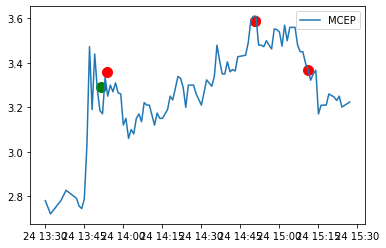

now=2020-04-24 09:50:56.771771
MBOT analysis for run 426 with profit 63.13


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1905.00,-1905.00,buy,2020-04-24 13:50:56.771771,7.50,"[5.9086, 6.0, 6.04, 6.1767, 6.28]",[7.8],254,"{'avg': 7.3473, 'rsi': 66.76367888025293, 'macd': [0.2209490678639856, 0.230875929586845, 0.2819231753288358, 0.29975081030812945, 0.30692003075848096], 'vwap': 7.5276, 'supports': [5.875, 5.9086, 6.0, 6.04, 6.1767, 6.28], 'sell_macd': [0.13874376717837933, 0.14446271654555254, 0.17693381064275915, 0.18759526304781904, 0.191263988778414], 'slow macd': [0.10382548072887676, 0.11101828186665497, 0.12666104967575542, 0.1370502398117157, 0.14571130560283851], 'macd_signal': [0.14473966660028578, 0.16196691919759762, 0.18595817042384527, 0.20871669840070212, 0.22835736487225788], 'resistances': [7.8], 'sell_macd_signal': [0.09079588126128793, 0.10152924831814085, 0.1166101607830645, 0.13080718123601542, 0.14289854274449515]}",8.65,7.14
1,-928.37,976.63,sell,2020-04-24 13:51:55.909997,7.69,None,None,127,"{'avg': 7.3585, 'rsi': [66.76367888025293, 69.5078608855972], 'vwap': 7.6874, 'reasons': 'scale-out', 'movement': 0.022606382978723513, 'sell_macd': [0.14446271654555254, 0.17693381064275915, 0.18759526304781904, 0.191263988778414, 0.20046995702591097], 'sell_macd_signal': [0.10152924831814085, 0.1166101607830645, 0.13080718123601542, 0.14289854274449515, 0.15441282560077832]}",8.65,7.14
2,-433.19,495.18,sell,2020-04-24 13:52:10.640101,7.86,None,None,63,"{'avg': 7.3936, 'rsi': [70.64830552859642, 71.78476681052422], 'vwap': 7.8344, 'reasons': 'scale-out', 'movement': 0.020806241872561672, 'sell_macd': [0.17693381064275915, 0.18759526304781904, 0.191263988778414, 0.20462580118175477, 0.21653596927290675], 'sell_macd_signal': [0.1166101607830645, 0.13080718123601542, 0.14289854274449515, 0.15524399443194709, 0.167502389400139]}",8.65,7.14
3,-173.99,259.20,sell,2020-04-24 14:09:39.353805,8.10,None,None,32,"{'avg': 7.4627, 'rsi': [65.44604052970594, 69.84792821884544], 'vwap': 7.9984, 'reasons': 'scale-out', 'movement': 0.021656050955414004, 'sell_macd': [0.06692283502068896, 0.06331887374564182, 0.06955320426189537, 0.08338316045297756, 0.10502490345313298], 'sell_macd_signal': [0.1040148363352913, 0.0958756438173614, 0.0906111559062682, 0.08916555681561007, 0.09233742614311466]}",8.65,7.14
4,63.13,237.12,sell,2020-04-24 14:30:08.904667,7.41,None,None,32,"{'avg': 7.7314, 'rsi': [38.72520156408476, 38.22529492577076], 'vwap': 7.45, 'reasons': 'below cost & macd negative & RSI trending down', 'movement': -0.09587378640776699, 'sell_macd': [0.06958092375432301, 0.049436678957364144, 0.029336791077171576, 0.005013024013680756, -0.014951119464541307], 'sell_macd_signal': [0.0964799271710243, 0.08707127752829227, 0.07552438023806814, 0.06142210899319066, 0.046147463301644265]}",8.65,7.14


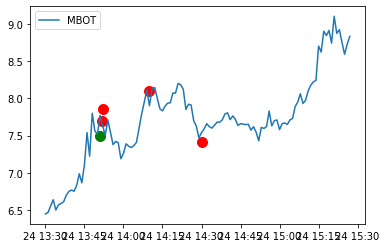

now=2020-04-24 09:52:51.752615
OSTK analysis for run 426 with profit 24.19


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-671.44,-671.44,buy,2020-04-24 13:52:51.752615,8.72,"[7.36, 7.5, 7.56, 7.91, 7.95, 8.0, 8.0, 8.05]",[8.7372],77,"{'avg': 8.106, 'rsi': 66.44318803469244, 'macd': [0.08193361009764821, 0.11457941973434238, 0.1295015848943244, 0.1445032631832639, 0.15939627878646867], 'vwap': 8.7451, 'supports': [7.36, 7.5, 7.56, 7.91, 7.95, 8.0, 8.0, 8.01, 8.05, 8.1], 'sell_macd': [0.05995762079560052, 0.08050027472215504, 0.08937376772048111, 0.09824436268384673, 0.10699749690616045], 'slow macd': [-0.028408208187435946, -0.01866067824014017, -0.011537243965173971, -0.0040053882104533756, 0.0038901822191572677], 'macd_signal': [-0.0124350602099325, 0.012967835778922479, 0.03627458560200286, 0.05792032111825507, 0.07821551265189779], 'resistances': [9.21, 9.5, 9.5, 9.5, 9.5, 9.53, 9.55], 'sell_macd_signal': [-0.000845062835265838, 0.015424004676218338, 0.030213957285070894, 0.043820038364826064, 0.05645553007309294]}",12.46,7.5
1,-332.86,338.58,sell,2020-04-24 13:53:19.999494,8.91,None,None,38,"{'avg': 8.1415, 'rsi': [65.7218656383995, 70.4998887244962], 'vwap': 8.9199, 'reasons': 'scale-out', 'movement': 0.020583524027459946, 'sell_macd': [0.08050027472215504, 0.08937376772048111, 0.09824436268384673, 0.10543905534771802, 0.12057986709427126], 'sell_macd_signal': [0.015424004676218338, 0.030213957285070894, 0.043820038364826064, 0.05614384176140445, 0.06903104682797781]}",12.46,7.5
2,-155.21,177.65,sell,2020-04-24 14:15:53.982761,9.35,None,None,19,"{'avg': 8.4773, 'rsi': [67.4342098231213, 70.17485325887195], 'vwap': 9.3419, 'reasons': 'scale-out', 'movement': 0.021836065573770463, 'sell_macd': [0.09147730729144499, 0.09477311218098095, 0.09509227037827017, 0.09930080572189581, 0.10647497864261624], 'sell_macd_signal': [0.09040402454724918, 0.09127784207399553, 0.09204072773485046, 0.09349274333225953, 0.09608919039433086]}",12.46,7.5
3,24.19,179.40,sell,2020-04-24 14:42:08.509014,8.97,None,None,20,"{'avg': 8.6251, 'rsi': [45.250932525823636, 44.6332860562792], 'vwap': 8.9812, 'reasons': 'below cost & macd negative & RSI trending down', 'movement': -0.03955164816359705, 'sell_macd': [0.016043280113395397, 0.01419333398818523, 0.004775280721940334, -0.0005527514429513047, -0.00521157194230959], 'sell_macd_signal': [0.02045771724660856, 0.019204840594923896, 0.016318928620327182, 0.012944592607671484, 0.009313359697675268]}",12.46,7.5


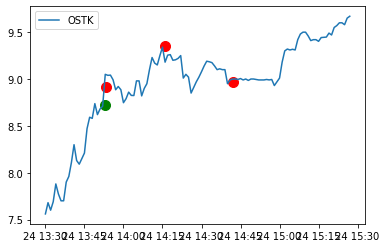

now=2020-04-24 10:32:35.123527
VXRT analysis for run 426 with profit -26.1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2653.5,-2653.5,buy,2020-04-24 14:32:35.123527,3.05,"[2.61, 2.7, 2.74, 2.76, 2.7701, 2.78, 2.81, 2.81, 2.955, 2.9631, 2.99]",[3.0902],870,"{'avg': 2.9755, 'rsi': 67.26880924042652, 'macd': [-0.0014943840385623908, -0.0002906790200101206, 0.0014614052995964855, 0.00512287984858073, 0.008810668969880808], 'vwap': 3.05, 'supports': [2.7701, 2.78, 2.81, 2.81, 2.955, 2.9631, 2.99], 'sell_macd': [-0.002200244120835748, -0.0013086151538770352, -7.216900879392085e-05, 0.0023935314809953034, 0.004855200284973993], 'slow macd': [0.030362285703840808, 0.0297742069647553, 0.029347071416376824, 0.029369371623300555, 0.029518845949425554], 'macd_signal': [-0.0006807719049959799, -0.000602753327998808, -0.00018992160247974937, 0.0008726386877323467, 0.002460244744162039], 'resistances': [3.0902], 'sell_macd_signal': [-0.002228488574065916, -0.00204451389002814, -0.0016500449137812963, -0.0008413296348259763, 0.00029797634913401763]}",3.38,2.94
1,-26.1,2627.4,sell,2020-04-24 15:04:26.645252,3.02,None,None,870,"{'avg': 2.999, 'rsi': [46.22510861796635, 42.166912130681936], 'vwap': 3.02, 'reasons': 'below cost & macd negative & RSI trending down', 'movement': -0.030497592295345165, 'sell_macd': [0.003531194705225449, 0.003340283527450083, 0.003137751654801235, 0.0017599638104668358, -0.0002196106631764394], 'sell_macd_signal': [0.004835093730881772, 0.004536131690195434, 0.004256455683116595, 0.003757157308586643, 0.0029618037142340264]}",3.38,2.94


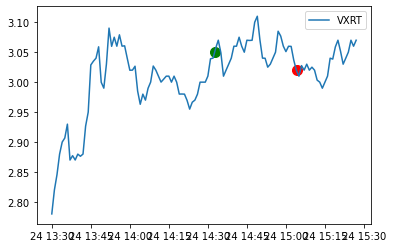

now=2020-04-24 09:57:12.170923
IVZ analysis for run 426 with profit -61.04


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3352.84,-3352.84,buy,2020-04-24 13:57:12.170923,7.69,"[7.3315, 7.47, 7.47, 7.4802, 7.495, 7.5, 7.5]",[7.905],436,"{'avg': 7.5119, 'rsi': 67.2689577320506, 'macd': [0.05721148037645918, 0.05852326275342978, 0.060479522305148414, 0.06212069976241885, 0.06507580233136423], 'vwap': 7.6907, 'supports': [7.3315, 7.47, 7.47, 7.47, 7.4802, 7.495, 7.5, 7.5], 'sell_macd': [0.03338291485990563, 0.034168249303779596, 0.0353754157625934, 0.036376124486830363, 0.03823153226562681], 'slow macd': [0.036324974802337096, 0.03786328845087361, 0.03953790122635503, 0.04117529922374796, 0.04309251297628869], 'macd_signal': [0.05867573563236224, 0.058645241056575745, 0.05901209730629028, 0.05963381779751599, 0.06072221470428564], 'resistances': [7.905], 'sell_macd_signal': [0.034889447765319506, 0.03474520807301153, 0.0348712496109279, 0.03517222458610839, 0.035784086122012074]}",8.36,7.48
1,-61.04,3291.80,sell,2020-04-24 14:15:08.715208,7.55,None,None,436,"{'avg': 7.5532, 'rsi': [39.4228228655761, 38.913448167570344], 'vwap': 7.5526, 'reasons': 'below cost & macd negative & RSI trending down', 'movement': -0.019455050780539745, 'sell_macd': [0.02169303355019636, 0.017959258178118276, 0.010401001288470546, 0.003597151747337435, -0.0020110057100053425], 'sell_macd_signal': [0.02892061472557109, 0.026728343416080526, 0.02346287499055853, 0.01948973034191431, 0.01518958313153038]}",8.36,7.48


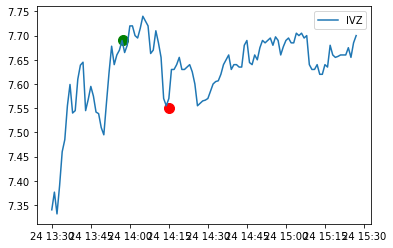

now=2020-04-24 09:53:07.773211
BSGM analysis for run 426 with profit -27.55


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1261.50,-1261.50,buy,2020-04-24 13:53:07.773211,8.70,"[7.32, 7.7, 7.7, 7.71, 7.71, 7.9, 7.93, 7.9402, 8.0, 8.0, 8.1]",[8.9],145,"{'avg': 8.4112, 'rsi': 71.11797232291615, 'macd': [0.16641068551756177, 0.1700593335246019, 0.16821984881758745, 0.17204110896089375, 0.17786071609355858], 'vwap': 8.6889, 'supports': [7.32, 7.7, 7.7, 7.71, 7.71, 7.9, 7.93, 7.9402, 8.0, 8.0, 8.1], 'sell_macd': [0.09646180173361074, 0.09868066547183929, 0.09733068052147509, 0.09969003405987209, 0.10335069871239178], 'slow macd': [0.13750172435621444, 0.1410707635882602, 0.1435753922242382, 0.14708952613966808, 0.15104700876055688], 'macd_signal': [0.17687141603495707, 0.17550899953288604, 0.17405116938982632, 0.1736491573040398, 0.17449146906194354], 'resistances': [8.9], 'sell_macd_signal': [0.10456336646394873, 0.10338682626552684, 0.10217559711671649, 0.10167848450534761, 0.10201292734675645]}",10.68,8.04
1,-27.55,1233.95,sell,2020-04-24 14:25:08.731793,8.51,None,None,145,"{'avg': 8.5353, 'rsi': [41.51886257578224, 40.782155416965296], 'vwap': 8.525, 'reasons': 'below cost & macd negative & RSI trending down', 'movement': -0.019770114942528602, 'sell_macd': [0.02644684801807884, 0.0216849446541012, 0.015355085608740993, 0.0055479865395149375, -0.002789337235718392], 'sell_macd_signal': [0.036635700828120475, 0.03364554959331662, 0.029987456796401496, 0.025099562745024184, 0.019521782748875668]}",10.68,8.04


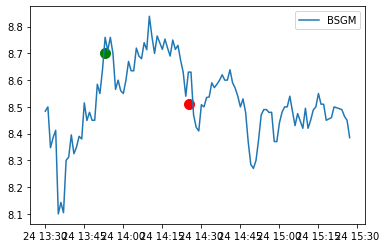

now=2020-04-24 10:22:40.773491
SRNE analysis for run 426 with profit -36.52


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2328.15,-2328.15,buy,2020-04-24 14:22:40.773491,2.55,"[2.26, 2.27, 2.28, 2.28, 2.29, 2.3001, 2.31, 2.34, 2.35, 2.473, 2.4778]",[2.5794],913,"{'avg': 2.4745, 'rsi': 67.68216291873867, 'macd': [0.008162754689854168, 0.009909323820041394, 0.01197048967622738, 0.013456924581487062, 0.016055619455050074], 'vwap': 2.5599, 'supports': [2.26, 2.27, 2.28, 2.28, 2.29, 2.3001, 2.31, 2.34, 2.35, 2.473, 2.4778], 'sell_macd': [0.00377513288600273, 0.004988140987817857, 0.006393236379000911, 0.00741028166591029, 0.00914031329641185], 'slow macd': [0.024342994382249294, 0.024401070081634835, 0.02457701086690456, 0.024701173883073135, 0.02509417444471751], 'macd_signal': [0.007107552164527142, 0.007667906495629992, 0.00852842313174947, 0.009514123421696987, 0.010822422628367604], 'resistances': [2.5794], 'sell_macd_signal': [0.002675419000589844, 0.0031379633980354467, 0.0037890179942285393, 0.00451327072856489, 0.0054386792421342815]}",2.87,2.46
1,-36.52,2291.63,sell,2020-04-24 14:45:07.142911,2.51,None,None,913,"{'avg': 2.4824, 'rsi': [47.502745728148135, 46.47152814469666], 'vwap': 2.515, 'reasons': 'below cost & macd negative & RSI trending down', 'movement': -0.017539747646392326, 'sell_macd': [0.002711345726186476, 0.0014441818993846667, 0.0004380259057805702, 1.1955963936216563e-05, -0.00042409796430531443], 'sell_macd_signal': [0.004544538285844137, 0.003924467008552243, 0.0032271787879979085, 0.00258413422318557, 0.001982487785687393]}",2.87,2.46


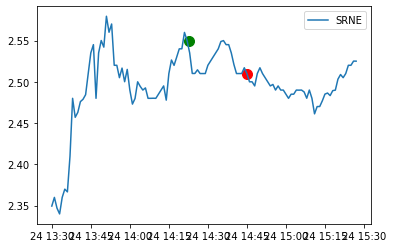

now=2020-04-24 09:49:18.899665
SRNE analysis for run 425 with profit -995.84


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-995.84,-995.84,buy,2020-04-24 13:49:18.899665,2.56,"[2.26, 2.27, 2.28, 2.28, 2.29, 2.3001, 2.31, 2.34, 2.35]","[2.57, 2.57, 2.59, 2.6]",389,"{'avg': 2.4402, 'rsi': 74.3265112580499, 'macd': [0.05558312467566262, 0.05867675633242442, 0.05605237365515858, 0.05693922627376624, 0.058979475746763654], 'vwap': 2.56, 'supports': [2.26, 2.27, 2.28, 2.28, 2.29, 2.3, 2.3001, 2.31, 2.34, 2.35], 'sell_macd': [0.03483551713957311, 0.03664993779961323, 0.03473585081003927, 0.035125707041409715, 0.03627201440297867], 'slow macd': [0.01977121674346094, 0.02189478299161607, 0.02293546544065217, 0.0245743572653101, 0.026442726981214193], 'macd_signal': [0.04200594040523663, 0.04534010359067418, 0.04748255760357106, 0.049373891337610096, 0.05129500821944081], 'resistances': [2.57, 2.57, 2.57], 'sell_macd_signal': [0.026607053803481887, 0.028615630602708157, 0.02983967464417438, 0.030896881123621447, 0.031971907779492895]}",3.3,2.31


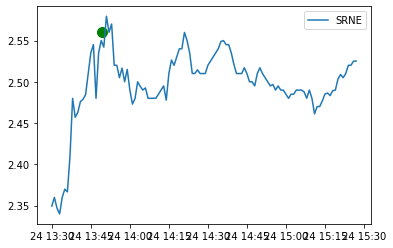

In [42]:
for run_id, count in runs.items():
    for symbol in minute_history:    
        if symbol not in trade_details[run_id]:
            continue
        start_date = datetime.strptime(start_day_to_analyze, "%Y-%m-%d") + timedelta(hours=9, minutes=30)
        minute_history_index = minute_history[symbol]["close"].index.get_loc(start_date, method='nearest')
        plt.plot(minute_history[symbol]["close"][minute_history_index:], label=symbol)

        delta = 0
        profit = 0
        
        operations = []
        deltas = []
        profits = []
        times = []
        prices = []
        qtys = []
        indicators = []
        target_price = []
        stop_price = []
        resistances = []
        supports = []
        for trade in trade_details[run_id][symbol]:
            resistance = None
            support = None
            if trade[0] == 'buy':
                resistance = find_resistance(trade[2], minute_history[symbol], trade[1])
                support = find_support(trade[2], minute_history[symbol], trade[1])
                
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
            profit += delta
            plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' or trade[0] == 'sell_short' else 'r', s=100)
            deltas.append(round(delta, 2))
            profits.append(round(profit, 2))
            operations.append(trade[0])
            times.append(pd.to_datetime(trade[1]))
            prices.append(trade[2])
            qtys.append(trade[3])
            indicators.append(trade[4])
            target_price.append(trade[6])
            stop_price.append(trade[5])    
            resistances.append(resistance)
            supports.append(support)
        d = {
            'profit': profits,
            'trade': deltas,
            'operation': operations,
            'at': times,
            'price': prices,
            'support': supports,
            'resistance': resistances,
            'qty': qtys,
            'indicators': indicators,
            'target price': target_price,
            'stop price': stop_price
        }   
        print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
        display(HTML(pd.DataFrame(data=d).to_html()))
        plt.legend()
        plt.show()

MCEP analysis for run 426
operation buy price 3.29 qty 171


TypeError: object of type 'Timestamp' has no len()

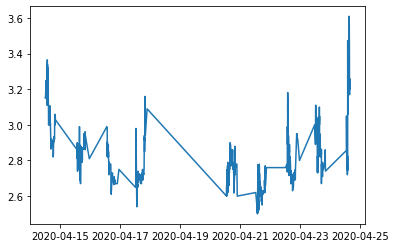

In [43]:
for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            print(symobl)
            continue
           
        print (f'{symbol} analysis for run {run_id}')
        plt.plot(minute_history[symbol]['close'], label=symbol)

        for trade in trade_details[run_id][symbol]:
            print(f'operation {trade[0]} price {trade[2]} qty {trade[3]}')

            plt.scatter(parser.isoparse(trade[1]), trade[2], c='g' if trade[0] == 'buy' else 'r', s=100)
    
        plt.legend()
        plt.show()

        min_time = trade_details[run_id][symbol][0][0]
        max_time = trade_details[run_id][symbol][-1][2]
        delta = 0 
        accumulative_delta = []
        
  #      if min_time not in minute_history[symbol]['close'] or max_time not in minute_history[symbol]['close']:
  #          continue
        plt.plot(minute_history[symbol]['close'][min_time:max_time], label=symbol)
                

        for trade in trade_details[run_id][symbol]:
 #           if trade[1] < high_15m[symbol]:
 #               continue
 #           t = parser.isoparse(trade[0])
 #           t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
 #           if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
 #               continue 

                
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            trade_delta = trade[3] - trade[1]
            delta += trade_delta 
            accumulative_delta.append(delta)
            
        plt.legend()
        plt.show()

        print(f'Delta = {delta}')
        plt.plot(range(len(accumulative_delta)), accumulative_delta)
        plt.show()

        for trade in trade_details[run_id][symbol]:
 #           if trade[1] < high_15m[symbol]:
 #               continue
#            t = parser.isoparse(trade[0])
#            t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
#            if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
#                continue

                
            plt.plot(minute_history[symbol]['close'][trade[0]:trade[2]])
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            plt.show()
            print(f"buy time:{trade[0]} sell time:{trade[2]}")
            print(trade[4])
            print(trade[5])



In [ ]:
 pd.Timestamp('2020-04-16 13:44:06.066') 

In [ ]:
index = minute_history['NURO'].index.get_loc(pd.Timestamp('2020-04-16 13:44:06.066') , method='nearest')

In [ ]:
minute_history['NURO'][:index]

In [ ]:
series = minute_history['NURO'][:2417]['close']

In [ ]:
MACD(series.dropna().between_time("9:30", "16:00"))